# Su Kalitesi ile ilgili Özelliklerin Analizi ve Suyun Kalitesini Tahmin Eden Makine Öğrenmesi Çalışması

Bu çalışmada **https://www.kaggle.com/datasets/adityakadiwal/water-potability** linkinde yer alan veri setini kullanarak özellik (feature) analizi ve makine öğrenmesi uygulaması yapacağız.

Koda geçmeden önce sütunlarımıza bir göz atalım,
- **pH Değeri (pH value):** Suyun asidik veya bazik dengesini gösterir. WHO'ya göre ideal aralık 6.5-8.5'tir. Mevcut değerler bu standartlara uygundur (6.52–6.83).
- **Sertlik (Hardness):** Suyun sertliği, kalsiyum ve magnezyum tuzlarının varlığına bağlıdır. Sert su, sabunla çökelek oluşturur ve jeolojik yapıdan geçerken bu tuzları toplar.
- **Çözünmüş Katılar (TDS):** Suda çözünmüş mineral ve tuzların (potasyum, kalsiyum, sodyum vb.) toplamını ifade eder. TDS değeri yüksek su, mineralleşmiş kabul edilir. İçme suyu için arzu edilen sınır 500 mg/L, maksimum sınır ise 1000 mg/L'dir.
- **Kloraminler (Chloramines):** Su dezenfeksiyonunda kullanılan klor ve amonyak bileşimidir. İçme suyu için 4 mg/L'ye kadar güvenli kabul edilir.
- **Sülfat (Sulfate):** Doğal olarak minerallerde ve toprakta bulunur. Tatlı sularda genellikle 3-30 mg/L arasında değişir. Bazı bölgelerde 1000 mg/L gibi yüksek değerler görülebilir.
- **Elektriksel İletkenlik (EC):** Sudaki iyon miktarını ve çözünmüş katıları ölçer. WHO standardına göre 400 μS/cm'yi aşmamalıdır.
- **Organik Karbon (Organic_carbon):** Suda bulunan organik maddelerden kaynaklanan toplam karbon miktarıdır. Arıtılmış su için < 2 mg/L, kaynak suları için < 4 mg/L olmalıdır.
- **Trihalometanlar (THM):** Klorlanmış sularda bulunan kimyasallardır. İçme suyu için 80 ppm'ye kadar güvenlidir.
- **Bulanıklık (Turbidity):** Sudaki askıda katı maddelerin miktarını gösterir. WHO'ya göre bulanıklık değeri 5.00 NTU'yu geçmemelidir.
- **İçilebilirlik (Potability):** Suyun insan tüketimi için güvenli olup olmadığını belirtir. 1 = İçilebilir, 0 = İçilemez.

artık kodumuza geçebiliriz.

## Kütüphanelerin Yüklenmesi

In [1498]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [1499]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn import tree

## Veri Seti Analizi ve Ön İşleme 

In [1501]:
df = pd.read_csv("water_potability.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Veri setimizi incelediğimizde eksik verilerimizin (missing values) varlığı dikkatimizi çekiyor. Ön işlemeye (Preprocessing) eksik verileri doldurarak başlayabiliriz.

### Eksik Veri Analizi

Veri setimizde eksik değerler bulunan sütunlar var ise eksik değerler yerine ilgili sütunun ortalamasını ya da medyanını yazacağız (Eğer ki veri setimiz gaussian bir dağılıma sahipse ortalamayı veya medyanı yazabiliriz fakat veri setimiz çarpık bir dağılıma sahipse o zaman ortalamayı yazamayız çünkü ortalama değeri anormal bir değere sahip olabilir. Dolayısıyla çarpık bir dağılımda eksik verileri doldurmak istersek medyan değerini kullanırız). Eğer ki null değerleri doldurmadan ön işlemeyi tamamlarsak hatalı bir veri seti ile çalışacağımızdan modelimiz (bazı algoritmalar eksik değerlerle başa çıkabilir ve onları otomatik olarak işleyebilir) öğrenme işlemi gerçekleştiremeyecektir. 

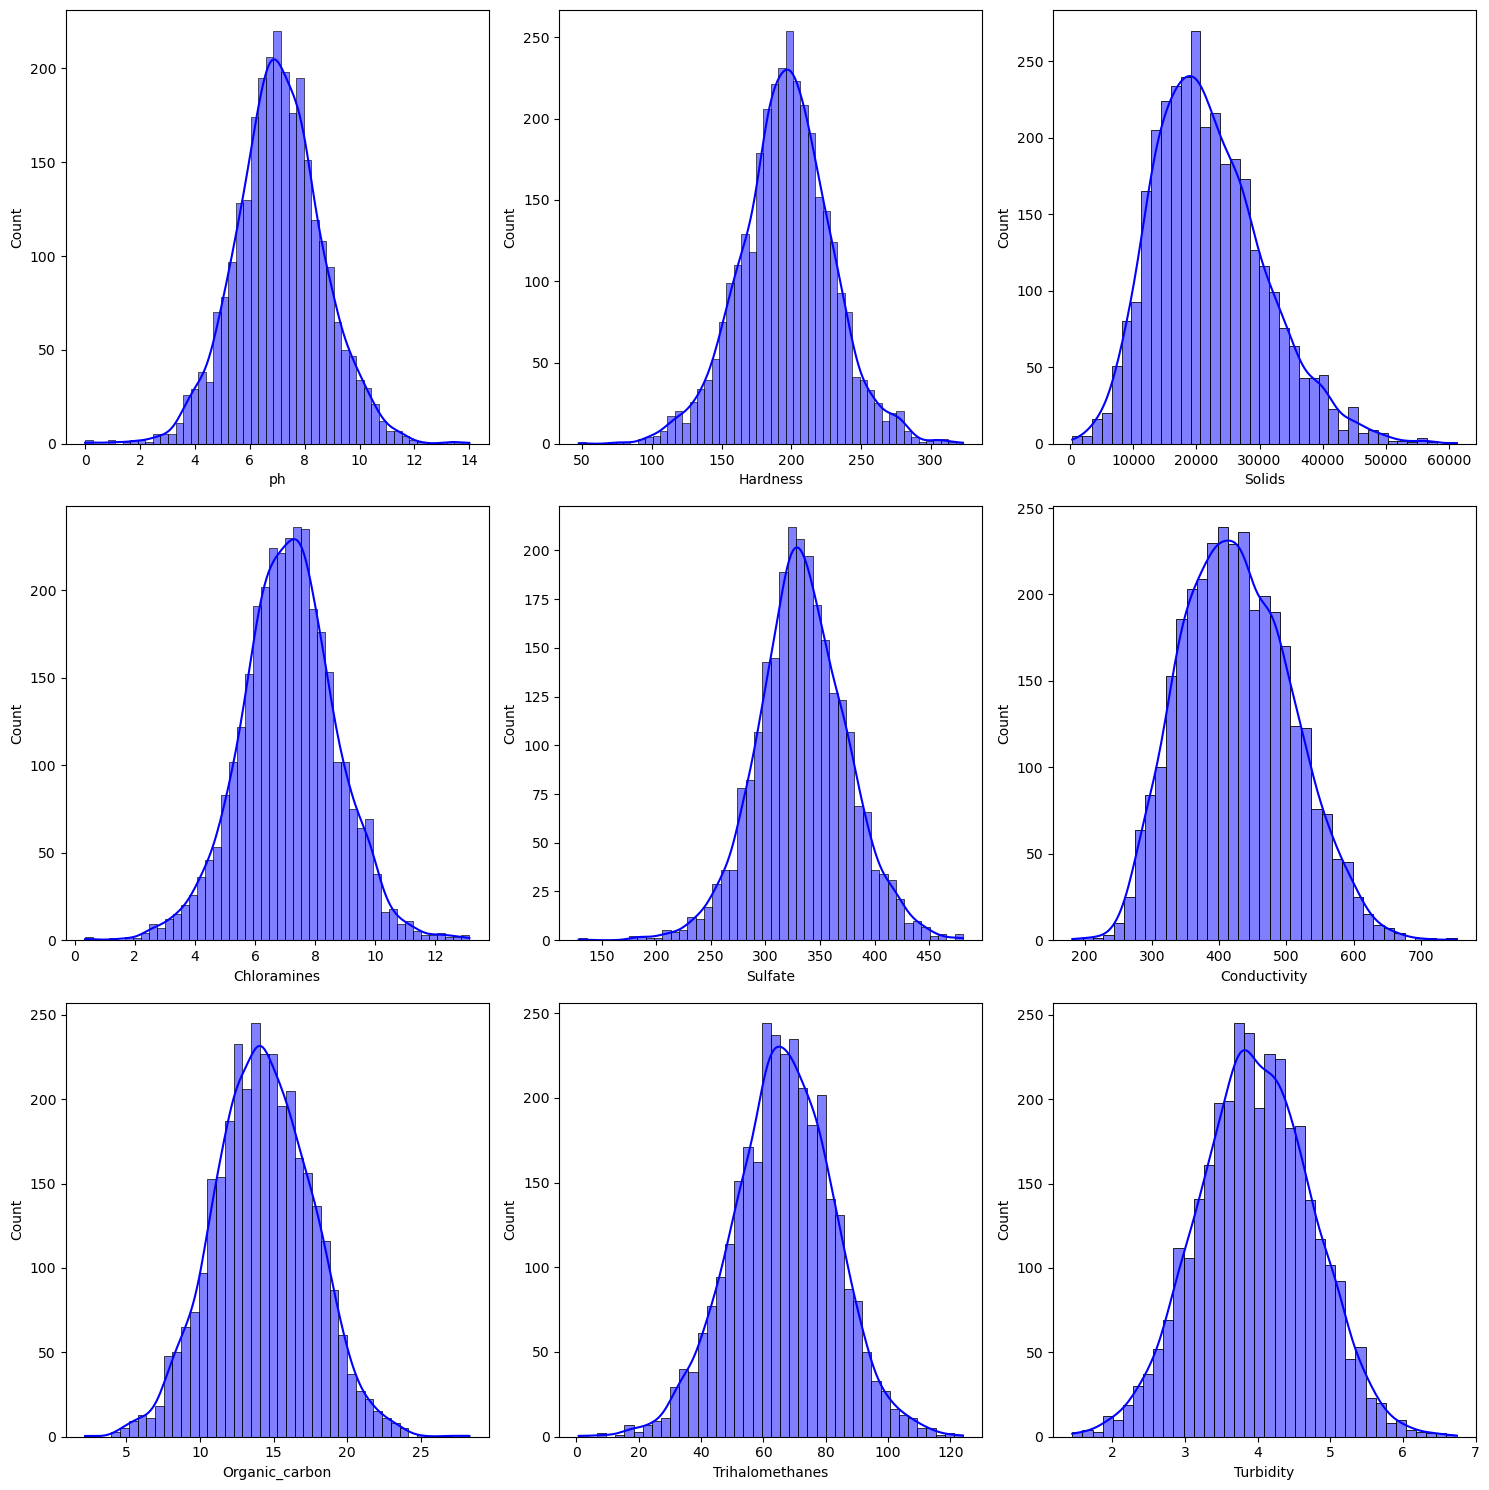

In [1505]:
# Özellik dağılımlarını analiz edelim, bu dağılımların çeşitlerine göre eksik verileri doldurma yöntemimizde değişkenlik olabilir.
# Histogram grafiği nasıl bir dağılım (Gaussian, sağa çarpık, sola çarpık...) olduğunu bize gösteren görsel bir analiz yöntemidir)
plt.figure(figsize=(15,15))
for i, column in enumerate(df.select_dtypes(["float64","int64"]).columns[:9], 1):
    plt.subplot(3,3,i)
    sns.histplot(data=df, x=column, color="blue", kde=True)

plt.tight_layout()
plt.show()

Eksik verilerin **"ph"**, **"Sulfate"** ve **"Trihalomethanes"** özelliklerinde olduğunu biliyoruz. Bu grafiklere ve Solids sütunu haricinde diğerlerine odaklanacak olursak Gaussian bir dağılıma sahip olduklarını söyleyebiliriz, yani bu sütunlarımızda yer alan eksik verileri istersek medyan istersek mean değerleri ile doldurabiliriz. **"Solids"** grafiğine bakacak olursak ise sağa çarpık bir dağılıma sahip olduğunu görüyoruz. Yani bu sütunda bir eksik veri olsaydı medyan değeri ile dolduracaktık.

Eksik verileri analiz edip doldurmaya başlayalım.
- **isnull():** Eksik verinin olduğu yerleri True olarak dönderir.
- **isna():** isnull() ile benzer işi yapar
- **notnull():** Eksik verinin olduğu yerleri False olarak dönderir.

Eksik verileri tespit ettikten sonra **"dropna()"** metodu ile çıkarabiliriz de fakat bu durum genelde tavsiye edilmez (10 satır gibi az sayıda eksik verileriniz varsa olabilir).

In [1508]:
# Eksik verilerin kaç tane ve hangi sütunlarda olduğunu net bir şekilde görelim
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

- **fillna():** Eksik değerleri doldurmamızda yardımcı olan bir method.

In [1510]:
# Eksik değerleri ortalamaları ile dolduruyoruz
df["ph"] = df["ph"].fillna(value= df["ph"].mean())  
df["Sulfate"] = df["Sulfate"].fillna(value= df["Sulfate"].mean())
df["Trihalomethanes"] = df["Trihalomethanes"].fillna(value= df["Trihalomethanes"].mean())

In [1511]:
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

### Korelasyon Analizi

Korelasyon analizi, iki veya daha fazla değişken arasındaki doğrusal ilişkinin yönünü ve derecesini ölçmek için kullanılan bir istatistiksel tekniktir. Yani iki değişkenin birlikte nasıl değiştiğini anlamamızı sağlar. Korelasyon değeri -1 ile 1 arasında değişmektedir. Negatif korelasyon öznitelikler (features) arasında ters orantı olduğunu ifade ederken pozitif korelasyon doğru orantı olduğunu ifade etmektedir. Korelasyonun gücü ise sayının büyüklüğü ile ilgilidir. Peki korelasyonun gücü nedir? Korelasyonun gücü ya da kuvveti, aralarındaki ilişinin ne kadar güçlü olduğunu ifade etmektedir. İki öznitelik arasındaki korelasyonun değeri 1 ise bu iki değişkeninde aynı yapıya ait olduğunu ve biri arttığı zaman aynı diğerinin de çok benzer şekilde arttığını ifade etmektedir. Bu örneğin benzerini -1 korelasyon sonucunda da düşünebiliriz, bu sefer ise iki öznitelik arasında ters orantılı olacak şekilde çok güçlü bir ilişki vardır. 0 korelasyon ise ilişki olmadığını belirtmektedir. Farklı korelasyon türleri olsa da en sık kullanılan **Pearson Korelasyonu** olarak bilinmektedir. Pearson korelasyonu, değişkenlerin sürekli yani sayısal olduğu durumlarda kullanılmaktadır.

In [1514]:
# Korelasyonu hesaplayalım
corr = df.corr() 

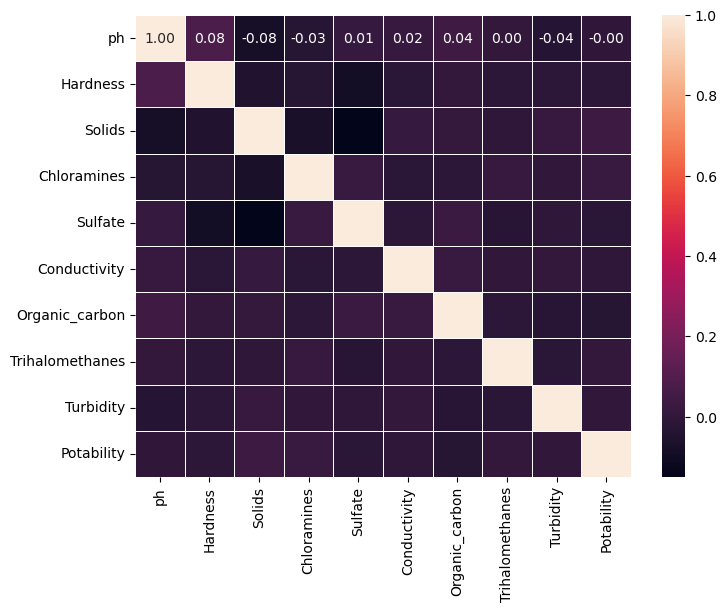

In [1515]:
# Görselleştirelim
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.7)
plt.show()

Korelasyonu analiz ettiğimizde çıktı sınfımız olan "Protability" ile çok güçlü ilişkisi olan bir özniteliğin olmadığını görüyoruz. Bu durum tüm özniteliklerimizin kullanılması gerektiğini ve özniteliklerin her birinin çıktı sınıfına etki edebileceğini söylerken, bir yandan da sınıflandırma işleminin zor olacağını ifade etmekte çünkü çıktı sınıfımızla güçlü bir ilişkiye sahip olan özniteliğimiz bulunmamakta.

### Aykırı Değer Analizi

Aykırı değerler, bir veri setinde diğer gözlemlerden çok farklı olan veri noktalarıdır. Makine öğrenmesi modellerinde aykırı değerler, model preformansının negatif anlamda etkilenmesine, istatiksel dağılımın bozulmasına ve modelin kötü kararlar vererek genelleştirme kabiliyetinin azalmasına neden olabilir. Aykırı değerler titiz bir şekilde analiz edilmeli ve gerekirse veri setinden çıkarılmalıdır. Burada kullandığım titiz ifadesini şu şekilde düşünmeliyiz, belirleyeceğimiz alt ve üst sınır gereğinden daha az olursa veri setinin yarısına yakını silinebilir. Gereğinden fazla olur ise aykırı değerlerin çoğunu tespit edemeyebiliriz. Projelerin çoğunda aykırı değerler tespit edilir ve veri setinden çıkarılır. Fakat bu değerlerin medyanla değiştirilmesi de ayrı bir seçenektir. Biz veri setimizin boyutunda bir azalma olmaması için aykırı değerleri ilgili sütunun üst ve alt sınırları ile değiştireceğiz. **Aykırı değer analizi için IQR yöntemini kullanacağız.**

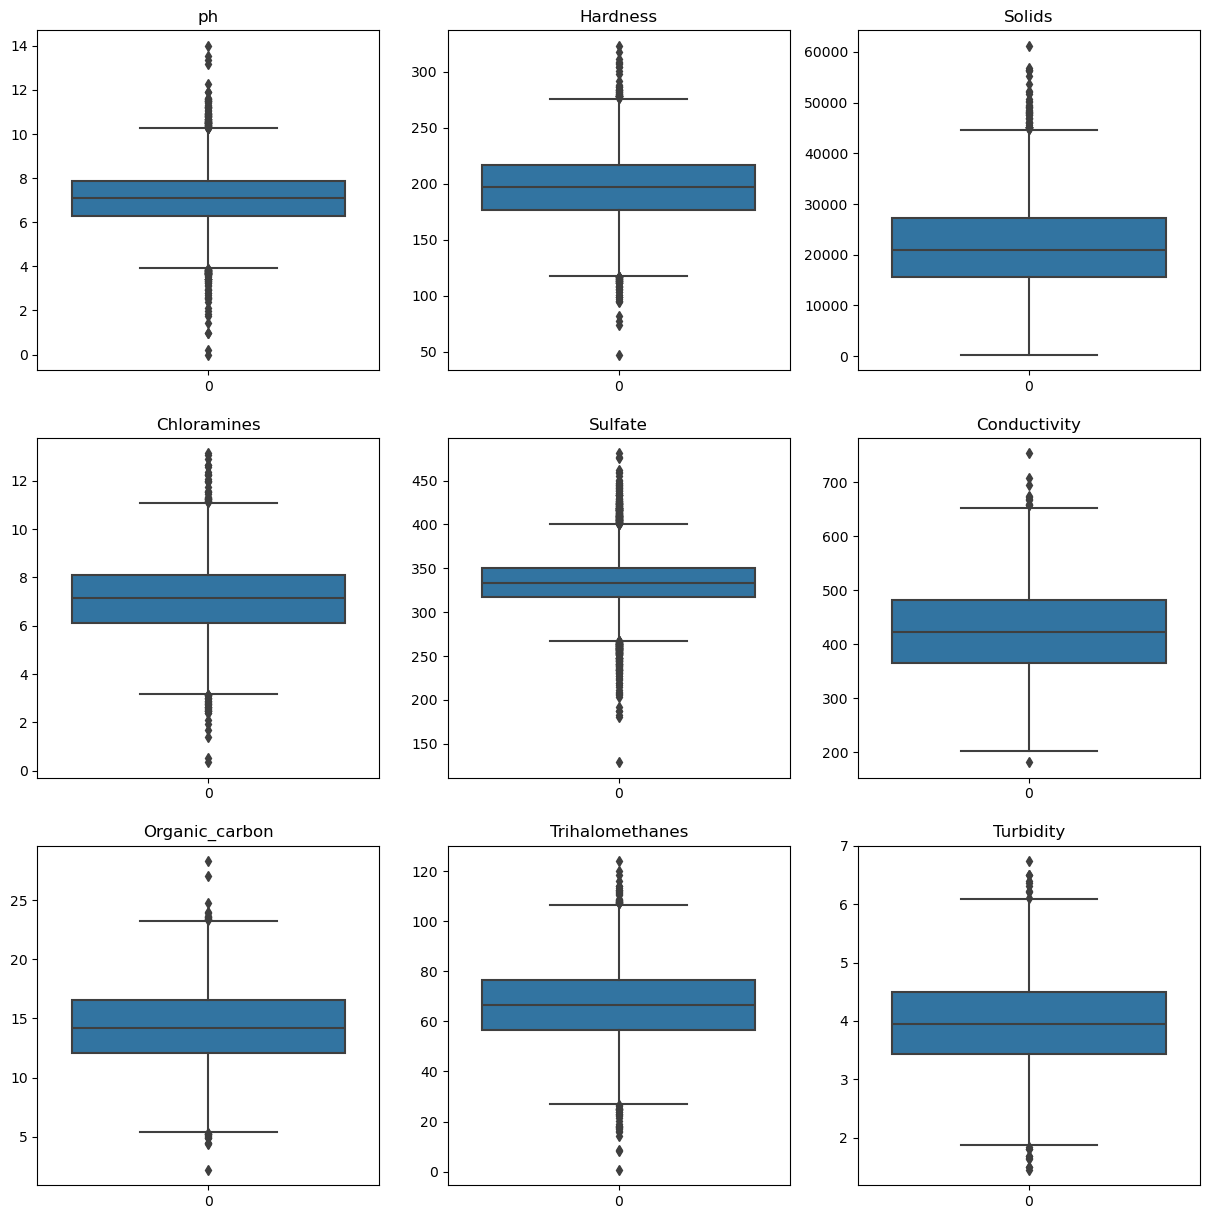

In [1519]:
# Tüm sütunların aykırı değerlerini analiz edelim ve sonrasında işleyelim.
plt.figure(figsize=(15,15))
for i, column in enumerate(df.columns[:9], 1):
    plt.subplot(3,3,i)
    sns.boxplot(df[column])
    plt.title(column)

Hızlı bir analiz yapacak olursak tüm sütunlarımızda aykırı değeler bulunduğunu görüyoruz fakat bu aykırı değerlerin sayısının değiştiğini söyleyebiliriz. ph sütununda aykırı değerlerin fazlalığı göze çarparken Conductivity sütununda ph sütunu kadar fazla aykırı değer olmadığını söyleyebiliriz. Şimdi bu aykırı değerleri tespit edelim ve işlemeye başlayalım.

In [1521]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1


In [1522]:
# IQR yönteminin uygulanması
for i, column in enumerate(df.columns[:9], 1):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    print(f"{column} sütununun üst limiti: {upper_limit}")
    print(f"{column} sütununda üst limitten sonra silinecek satır sayısı: {len(df.loc[df[column] > upper_limit, column])}")
    print(f"{column} sütununun alt limiti: {lower_limit}")
    print(f"{column} sütununda alt limitten sonra silinecek satır sayısı: {len(df.loc[df[column] < lower_limit, column])}")
    print("---")
    df = df.drop(df[df[column] > upper_limit].index)
    df = df.drop(df[df[column] < lower_limit].index)

ph sütununun üst limiti: 10.258615434291345
ph sütununda üst limitten sonra silinecek satır sayısı: 75
ph sütununun alt limiti: 3.889106956840228
ph sütununda alt limitten sonra silinecek satır sayısı: 67
---
Hardness sütununun üst limiti: 275.6815405479356
Hardness sütununda üst limitten sonra silinecek satır sayısı: 36
Hardness sütununun alt limiti: 118.27285633989479
Hardness sütununda alt limitten sonra silinecek satır sayısı: 38
---
Solids sütununun üst limiti: 44493.92700066374
Solids sütununda üst limitten sonra silinecek satır sayısı: 41
Solids sütununun alt limiti: -1629.6517252548038
Solids sütununda alt limitten sonra silinecek satır sayısı: 0
---
Chloramines sütununun üst limiti: 11.06004894065866
Chloramines sütununda üst limitten sonra silinecek satır sayısı: 27
Chloramines sütununun alt limiti: 3.1900915438899875
Chloramines sütununda alt limitten sonra silinecek satır sayısı: 25
---
Sulfate sütununun üst limiti: 399.8142826661651
Sulfate sütununda üst limitten sonra sil

In [1523]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
...,...,...,...,...,...,...,...,...,...,...
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1
3272,7.808856,193.553212,17329.802160,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1


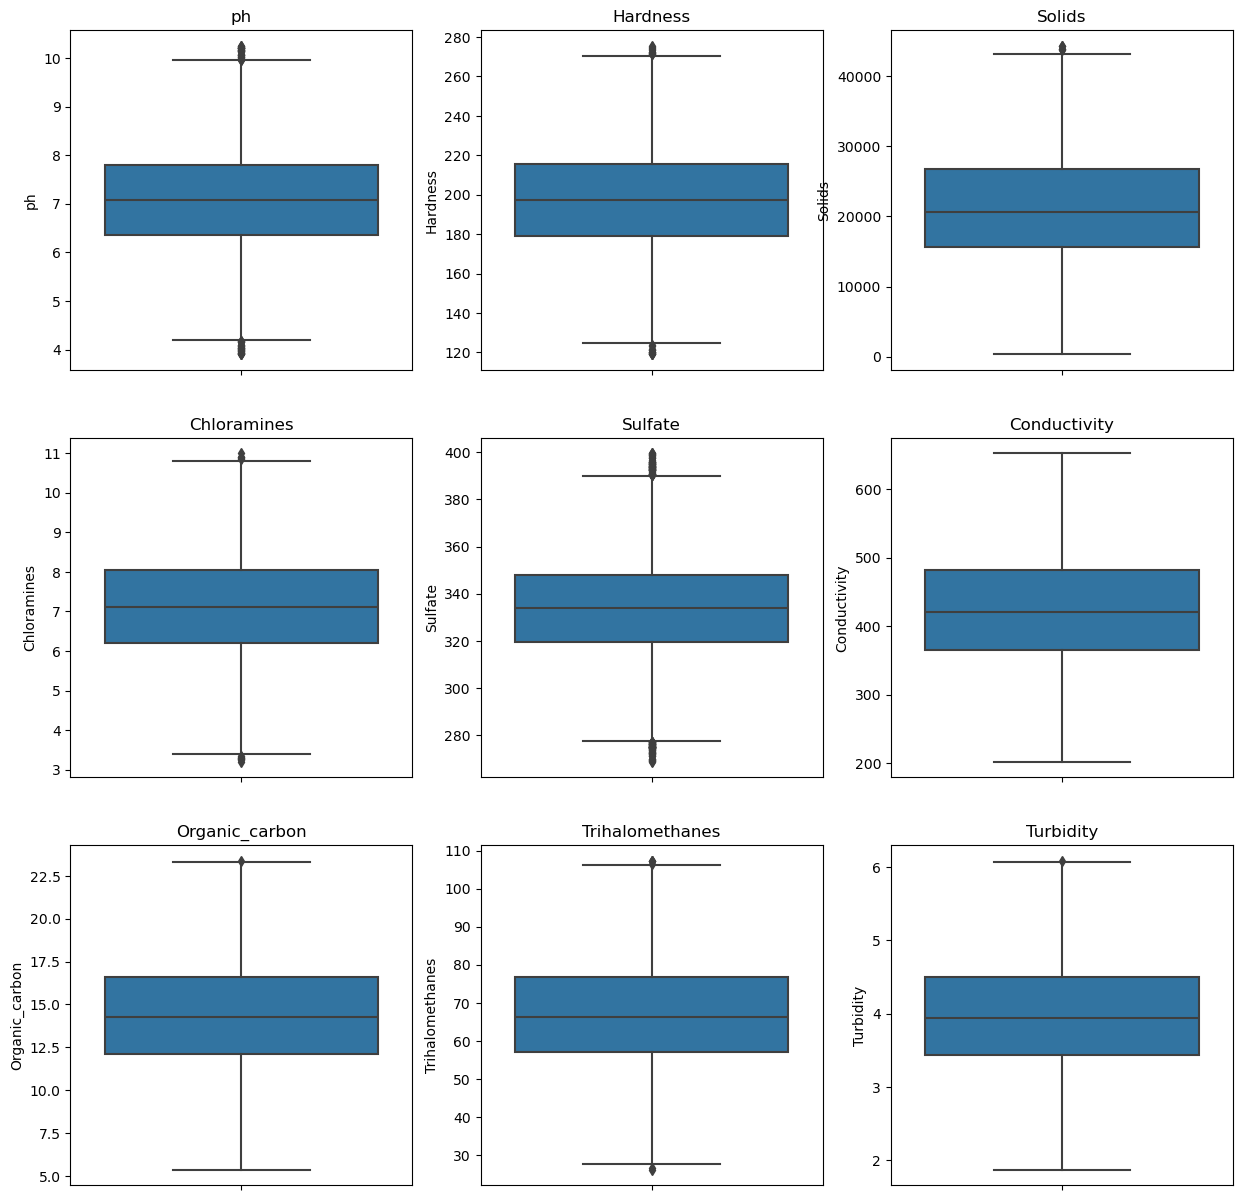

In [1524]:
# Tüm sütunların aykırı değerlerine tekrar bakalım
plt.figure(figsize=(15,15))
for i, column in enumerate(df.columns[:9], 1):
    plt.subplot(3,3,i)
    sns.boxplot(data=df, y=column) 
    plt.title(column)

### Veri Seti Ayrımı (Train-Test) ve Normalizasyon İşlemi

In [1526]:
X = df.drop("Potability", axis=1).values
y = df["Potability"].values

In [1527]:
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [1528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1529]:
print("X Train:", X_train.shape)
print("X Test:", X_test.shape)
print("y Train:", y_train.shape)
print("y Test:", y_test.shape)

X Train: (1859, 9)
X Test: (798, 9)
y Train: (1859,)
y Test: (798,)


In [1530]:
# Veri setini ayırma işlemi bittikten sonra normalizasyon işlemini yapabiliriz (min-max normalizasyonu).
x_train_max = np.max(X_train)
x_train_min = np.min(X_train)
X_train = (X_train - x_train_min) / (x_train_max - x_train_min)
X_test = (X_test - x_train_min) / (x_train_max - x_train_min)

## Model Geliştirme
Bu aşamada farklı makine öğrenmesi algoritmaları kullanacağız. Hepsinin performans metriğini karşılaştıracağız ve yorumlarda bulunacağız.

### Logistic Regression Algoritması

In [1533]:
logistic_regression = LogisticRegression()

In [1534]:
# Model Eğitimi
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [1535]:
y_pred_prob = logistic_regression.predict_proba(X_test)
y_pred_prob

array([[0.62374505, 0.37625495],
       [0.61381316, 0.38618684],
       [0.62231878, 0.37768122],
       ...,
       [0.6234516 , 0.3765484 ],
       [0.63067966, 0.36932034],
       [0.62324304, 0.37675696]])

In [1536]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Confusion Matrix:
[[505   0]
 [293   0]]


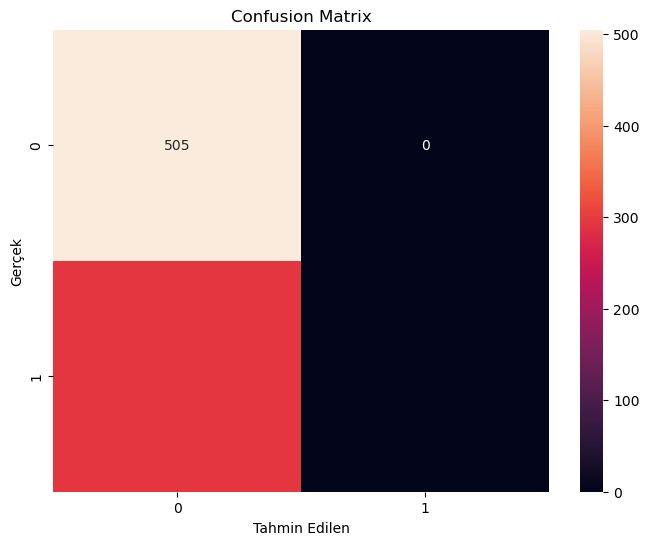

In [1537]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Confusion Matrix'i görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [1538]:
accuracy = accuracy_score(y_pred,y_test) # Tahmin ettiğimiz değerler ile test için hazırladığımız veri setinin karşılaştırılması sonucunda ortaya çıkan değerimize bakalım
print(f"Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): {accuracy}")

Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): 0.6328320802005013


In [1539]:
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score (Weighted): {f1}")

F1-Score (Weighted): 0.4905298549520386


In [1540]:
# Precision Hesaplama
precision = precision_score(y_pred, y_test)
print(f"Precision: {precision:.2f}")

# Recall Hesaplama
recall = recall_score(y_pred, y_test)
print(f"Recall: {recall:.2f}")

Precision: 0.00
Recall: 0.00


### Decision Tree Algoritması

In [1542]:
decision_tree = DecisionTreeClassifier()

In [1543]:
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [1544]:
y_pred = decision_tree.predict(X_test)
y_pred

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [1545]:
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): {accuracy}")

Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): 0.600250626566416


Confusion Matrix:
[[347 161]
 [158 132]]


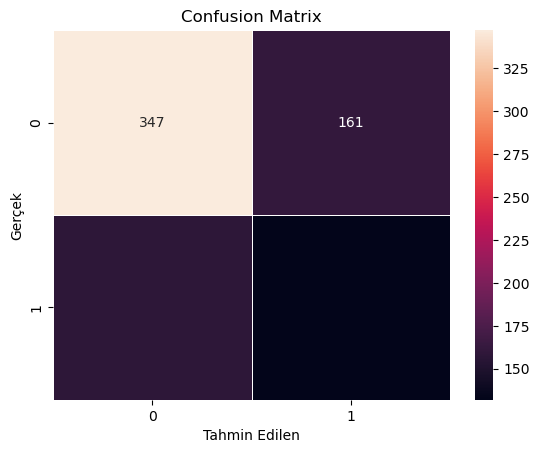

In [1546]:
cm = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot= True, fmt= "d", linewidth= .7, xticklabels = decision_tree.classes_, yticklabels = decision_tree.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [1547]:
f1 = f1_score(y_pred, y_test)
print(f"F1-Score (Weighted): {f1}")

F1-Score (Weighted): 0.45283018867924524


In [1548]:
# Precision Hesaplama
precision = precision_score(y_pred, y_test)
print(f"Precision: {precision:.2f}")

# Recall Hesaplama
recall = recall_score(y_pred, y_test)
print(f"Recall: {recall:.2f}")

Precision: 0.45
Recall: 0.46


### Random Forest Algoritması

In [1550]:
random_forest = RandomForestClassifier()

In [1551]:
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [1552]:
y_pred = random_forest.predict(X_test)

In [1553]:
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): {accuracy}")

Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): 0.650375939849624


Confusion Matrix:
[[447 221]
 [ 58  72]]


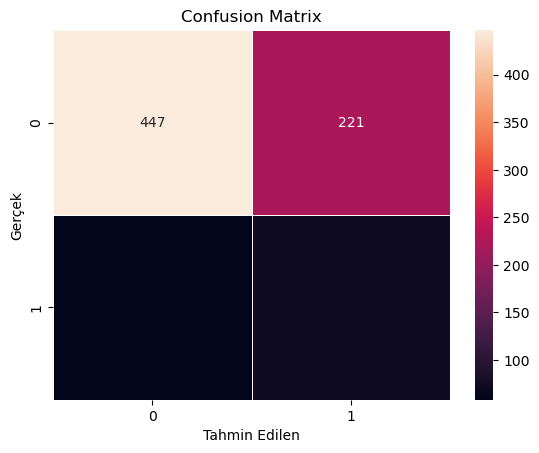

In [1554]:
cm = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, linewidths=.7, fmt="d")
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [1555]:
f1 = f1_score(y_pred, y_test, average='weighted')
print(f"F1-Score (Weighted): {f1}")

F1-Score (Weighted): 0.6934466273972466


In [1556]:
# Precision Hesaplama
precision = precision_score(y_pred, y_test)
print(f"Precision: {precision:.2f}")

# Recall Hesaplama
recall = recall_score(y_pred, y_test)
print(f"Recall: {recall:.2f}")

Precision: 0.25
Recall: 0.55


### Gradient Boosting Algoritması

In [1558]:
gradient_boosting = GradientBoostingClassifier()

In [1559]:
gradient_boosting.fit(X_train, y_train)

GradientBoostingClassifier()

In [1560]:
y_pred = gradient_boosting.predict(X_test)
y_pred

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,

Confusion Matrix:
[[459 245]
 [ 46  48]]


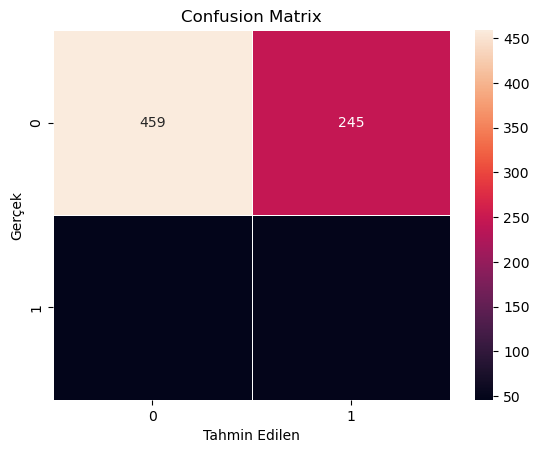

In [1561]:
cm = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, linewidths=.7, fmt="d")
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [1562]:
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): {accuracy}")

Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): 0.6353383458646616


In [1563]:
f1 = f1_score(y_pred, y_test, average='weighted')
print(f"F1-Score (Weighted): {f1}")

F1-Score (Weighted): 0.6990835813831037


In [1564]:
# Precision Hesaplama
precision = precision_score(y_pred, y_test)
print(f"Precision: {precision:.2f}")

# Recall Hesaplama
recall = recall_score(y_pred, y_test)
print(f"Recall: {recall:.2f}")

Precision: 0.16
Recall: 0.51


### Naive Bayes Algortiması

In [1566]:
naive_bayes = GaussianNB()

In [1567]:
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [1568]:
y_pred = naive_bayes.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Confusion Matrix:
[[468 267]
 [ 37  26]]


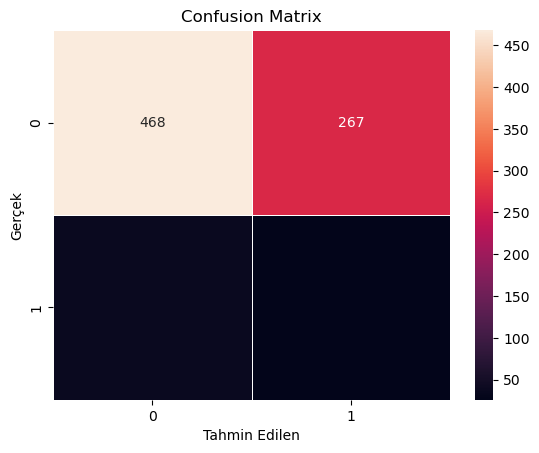

In [1569]:
cm = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, linewidths=.7, fmt="d")
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [1570]:
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): {accuracy}")

Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): 0.6190476190476191


In [1571]:
f1 = f1_score(y_pred, y_test, average='weighted')
print(f"F1-Score (Weighted): {f1}")

F1-Score (Weighted): 0.7067778180500182


In [1572]:
# Precision Hesaplama
precision = precision_score(y_pred, y_test)
print(f"Precision: {precision:.2f}")

# Recall Hesaplama
recall = recall_score(y_pred, y_test)
print(f"Recall: {recall:.2f}")

Precision: 0.09
Recall: 0.41


### En Yakın Komşu (KNN) Algoritması

In [1574]:
knn = KNeighborsClassifier()

In [1575]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [1576]:
y_pred = knn.predict(X_test)

Confusion Matrix:
[[357 217]
 [148  76]]


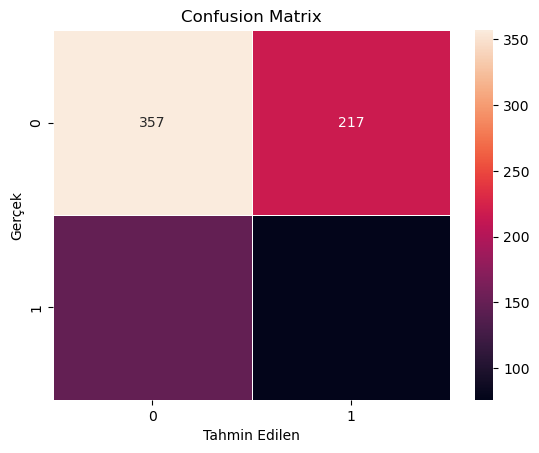

In [1577]:
cm = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, linewidths=.7, fmt="d")
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [1578]:
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): {accuracy}")

Test Veri Setindeki Doğruluk Oranımız (Test Accuracy): 0.5426065162907269


In [1579]:
f1 = f1_score(y_pred, y_test, average='weighted')
print(f"F1-Score (Weighted): {f1}")

F1-Score (Weighted): 0.5585041832967467


In [1580]:
# Precision Hesaplama
precision = precision_score(y_pred, y_test)
print(f"Precision: {precision:.2f}")

# Recall Hesaplama
recall = recall_score(y_pred, y_test)
print(f"Recall: {recall:.2f}")

Precision: 0.26
Recall: 0.34
